In [1]:
import pandas as pd
import numpy as np

# 1. Load in datasets

In [2]:
addr_train = "C:/Users/poduo/Anaconda3_JupyterNB/SC00030 Python ML & DL/HW_Practice/Kaggle_Titanic/DataSet/train.csv"
addr_test = "C:/Users/poduo/Anaconda3_JupyterNB/SC00030 Python ML & DL/HW_Practice/Kaggle_Titanic/DataSet/test.csv"

train = pd.read_csv(addr_train)
test = pd.read_csv(addr_test)

ori_train = train.copy()
ori_test = test.copy()

full_data = [train, test]

In [3]:
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
522,523,0,3,"Lahoud, Mr. Sarkis",male,NaN,0,0,2624,7.2250,NaN,C
842,843,1,1,"Serepeca, Miss. Augusta",female,30.0,0,0,113798,31.0000,NaN,C
228,229,0,2,"Fahlstrom, Mr. Arne Jonas",male,18.0,0,0,236171,13.0000,NaN,S
640,641,0,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S
226,227,1,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.5000,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# 2. Feature Engineering
form https://www.kaggle.com/sinakhorami/titanic-best-working-classifier

### Pclass 艙等
名義量尺

1 = 1st, 2 = 2nd, 3 = 3rd

In [6]:
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


### Sex 性別
名義量尺

In [7]:
print (train[['Sex', 'Survived']].groupby(['Sex'], as_index= False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


### SibSp & Parch
比率量尺

In [8]:
# 計算 家庭成員 + 自己
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp']+ dataset['Parch']+ 1

print(train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index= False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


### 新增 IsAlone 欄位
1 獨自乘船；0 與家人乘船

名義量尺

In [9]:
#非獨自一人 0(False，有家庭成員)；獨自一人 1(True，沒有家庭成員)
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index= False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


### Embarked 
上船地點：名義量尺

C = Cherbourg, Q = Queenstown, S = Southampton

In [10]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index= False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


### Fare
票價：比率量尺
#### 遺失值：補入中位數

In [11]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# 使用 4 分位數 做分箱
train['CategoricalFare'] = pd.qcut(train['Fare'],4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index= False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


### Age
年齡；比率量尺
#### 遺失值：隨機填入 平均+-標準差 的值
作 分箱pcut

In [12]:
# 將 遺失值 隨機放入 平均值+-標準差範圍的 整數
for dataset in full_data:
    age_mean = train['Age'].mean() # dataset['Age'].mean()
    age_std = train['Age'].std() # dataset['Age'].std()
    
    age_null_count = dataset['Age'].isnull().sum()
    age_random_list = np.random.randint(age_mean - age_std, age_mean + age_std, size = age_null_count)
    #     series = series
    dataset['Age'][np.isnan(dataset['Age'])] = age_random_list
    dataset['Age'] = dataset['Age'].astype(int)

    # 分箱 right = True ， <=
train['CategoricalAge'] = pd.cut(train['Age'], 5)
print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index= False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.525424
1   (16.0, 32.0]  0.346241
2   (32.0, 48.0]  0.381890
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


C:\Users\poduo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Name

In [13]:
import re

In [14]:
def get_title(name):
    title = re.search(' ([\w]+)\.', name)
    if title:
        return title.group(1)
    return ''
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [15]:
print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [16]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


# 3. Data Cleaning
clean our data and map our features into numerical values.

In [17]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)
    
    # Mapping titles ....OneHotEncoding??
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked ...OneHotEncoding??
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'FamilySize']

train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test = test.drop(drop_elements, axis = 1)

print (train.head(10))
print (test.head(10))

train = train.values
test = test.values

   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0         0       3    1    1     0         0        0      1
1         1       1    0    2     3         1        0      3
2         1       3    0    1     1         0        1      2
3         1       1    0    2     3         0        0      3
4         0       3    1    2     1         0        1      1
5         0       3    1    2     1         2        1      1
6         0       1    1    3     3         0        1      1
7         0       3    1    0     2         0        0      4
8         1       3    0    1     1         0        0      3
9         1       2    0    0     2         1        0      3
   Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0       3    1    2     0         2        1      1
1       3    0    2     0         0        0      3
2       2    1    3     1         2        1      1
3       3    1    1     1         0        1      1
4       3    0    1     1         0        0      3
5     

In [18]:
train

array([[0, 3, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 1, 0, 3],
       [1, 3, 0, ..., 0, 1, 2],
       ..., 
       [0, 3, 0, ..., 0, 0, 2],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 3, 1, ..., 2, 1, 1]], dtype=int64)

# Classifier Comparison

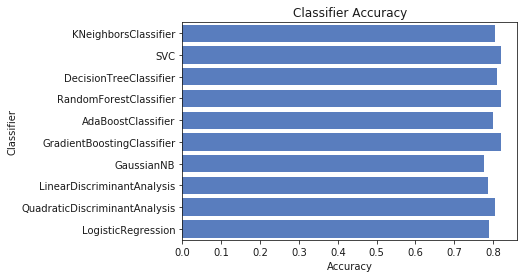

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log  = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}
f1_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        f1 = f1_score(y_test, train_predictions) 
        if name in acc_dict:
            acc_dict[name] += acc
            f1_dict[name] += f1
        else:
            acc_dict[name] = acc
            f1_dict[name] = f1

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [24]:
acc_dict

{'AdaBoostClassifier': 0.79999999999999993,
 'DecisionTreeClassifier': 0.80888888888888888,
 'GaussianNB': 0.77555555555555555,
 'GradientBoostingClassifier': 0.82111111111111124,
 'KNeighborsClassifier': 0.80555555555555536,
 'LinearDiscriminantAnalysis': 0.78777777777777769,
 'LogisticRegression': 0.78888888888888886,
 'QuadraticDiscriminantAnalysis': 0.80444444444444441,
 'RandomForestClassifier': 0.81333333333333324,
 'SVC': 0.82111111111111101}

In [27]:
f1_dict

{'AdaBoostClassifier': 7.4640328955598001,
 'DecisionTreeClassifier': 7.3916356077846617,
 'GaussianNB': 7.2716720214212334,
 'GradientBoostingClassifier': 7.4779585031502824,
 'KNeighborsClassifier': 7.5134475403029786,
 'LinearDiscriminantAnalysis': 7.2222236886045827,
 'LogisticRegression': 7.2745567550361248,
 'QuadraticDiscriminantAnalysis': 7.4873891944572195,
 'RandomForestClassifier': 7.6354712385354837,
 'SVC': 7.4800322217728965}

In [21]:
import xgboost as xgb

In [22]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(X_train, y_train)

predictions = gbm.predict(X_test)

In [23]:
gbm.score(X_test, y_test)

0.85555555555555551

Pclass 是否要 Label encoding ?